In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn

In [3]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Data Split

In [4]:
PATH = '/content/drive/MyDrive/PR/data/'

In [5]:
df = pd.read_csv(PATH + 'IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


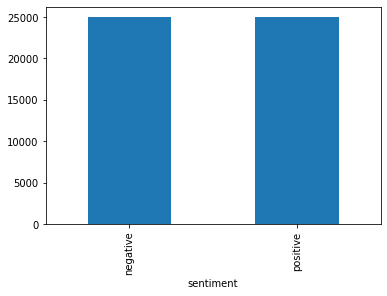

In [6]:
df.groupby(['sentiment']).size().plot.bar()


In [7]:
labels = {'positive' : 0,
         'negative' : 1}

In [8]:
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])

In [9]:
df_train, df_val = train_test_split(df_train_val, test_size=0.1, random_state=42, stratify=df_train_val['sentiment'])

# 2.Text Pre-processing


In [10]:
BATCH_SIZE = 8
EPOCHS  = 2
NUM_WORKERS = 2
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cpu")
DEVICE

device(type='cpu')

In [11]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = RegexpTokenizer(r'\w+')
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = df.iloc[idx]
        sentence = row['review']
        y = labels[row['sentiment']]
        sentence = sentence.lower()
        tokens = self.tokenizer.tokenize(sentence)
        filtered_words = [w for w in tokens if not w in stopwords.words('english')]
        lemmaized = self.lemmatizer.lemmatize(" ".join(filtered_words))
        X = self.bert_tokenizer(lemmaized, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
        return X, y

In [13]:
train_dataset = Dataset(df_train[:10])
test_dataset = Dataset(df_test[:20])
val_dataset = Dataset(df_val[:10])

print(len(df_train))

36000


In [14]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [15]:
len(train_dataloader)

2

# 3.Classification using BERT

In [16]:
class BertClassifier(nn.Module):
  def __init__(self, h1, h2, h3, h4, dropout=0.5, ):
    super(BertClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased', num_labels = 2, )
    self.dropout = nn.Dropout(dropout)
    self.l1 = nn.Linear(768, h1)
    self.l2 = nn.Linear(h1, h2)
    self.l3 = nn.Linear(h2, h3)
    self.l4 = nn.Linear(h3, h4)
    self.output = nn.Linear(h4, 1)

  def forward(self, input_id, mask):
    _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
    x = self.dropout(pooled_output)
    x = self.l1(x)
    x = self.l2(x)
    x = self.l3(x)
    x = self.l4(x)
    return nn.Sigmoid()(self.output(x))

In [17]:
def run_model(data_loader, optimizer, criterion, device, train = True):

  if train:
    model.train(mode=True)
  else:
    model.train(mode = False)

  total_acc = 0
  total_loss = 0

  for sample, label in tqdm(data_loader):
    

    label = label.to(device)
    mask = sample['attention_mask'].to(device)
    input_id = sample['input_ids'].squeeze(1).to(device)
    output = model(input_id, mask)
    batch_loss = criterion(output.flatten(), label.to(torch.float32))
    total_loss += batch_loss.item()
    
    acc = (output.argmax(dim=1) == label).sum().item()
    total_acc += acc

    if train:
      model.zero_grad()
      batch_loss.backward()
      optimizer.step()

  return total_loss, total_acc


In [18]:
def train(model, train_dataloader, val_dataloader, optimizer, criterion, device):


    
  total_loss_train, total_acc_train = run_model(train_dataloader, optimizer, criterion, device)

  with torch.no_grad():

    total_loss_val, total_acc_val = run_model(val_dataloader, optimizer, criterion, device, False)

  return total_acc_train, total_loss_train, total_acc_val, total_loss_val
          
  

In [19]:
LR = 1e-3

In [20]:
model = BertClassifier(512, 256, 128, 64)
model = model.to(DEVICE)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [27]:
print(train(model, train_dataloader, val_dataloader, optimizer, criterion, DEVICE))

100%|██████████| 2/2 [00:21<00:00, 10.58s/it]

(23, 5.040403962135315, 7, 1.5467511415481567)


In [ ]:
# Load Model 
model = torch.load(PATH + 'model.pth')

# 4.Validation and Hyperparameter Tuning

In [39]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
EPOCHS = 2

optimizer = torch.optim.Adam(model.parameters(), lr= LR)

best_loss = float('inf')
best_acc = None
best_params = None

train_losses = []
val_losses = []

for i in range(EPOCHS):

  train_acc, train_loss, val_acc, val_loss = train(model, train_dataloader, val_dataloader, optimizer, criterion, DEVICE)

  if val_loss < best_loss:

    best_loss, best_acc, best_params = val_loss, val_acc, model.parameters()

  train_losses.append(train_loss)
  val_losses.append(val_loss) 

x = [i+1 for i in range(EPOCHS)]

plt.plot(x, train_losses, label="Train loss")
plt.plot(x, val_losses, label = "Validation loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Loss vs epoch")
    




  0%|          | 0/7 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14ae23f170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f14ae23f170>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if

RuntimeError: ignored

##Tuning learning rate

In [22]:
class Params:

  def __init__(self):
    self.losses = []
    self.accs = []
    self.params = []

  def update(self, loss, acc, param):

    self.losses.append(loss)
    self.accs.append(acc)
    self.params.append(param)

  def get_params(self):

    return self.losses, self.accs, self.params

100%|██████████| 2/2 [00:20<00:00, 10.46s/it]


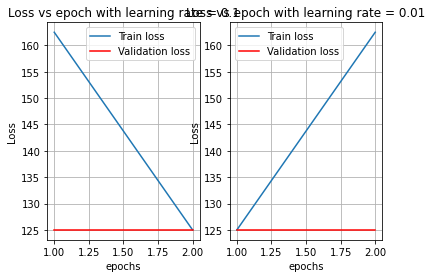

Best loss: 1
Best accuracy: 2
Best learning rate: 0


In [24]:
learning_rates = [0.1, 0.01]
EPOCHS = 2

params = Params()
best_losses = [float('inf')]*len(learning_rates)

params.update(1, 2, model.parameters())


fig, axs = plt.subplots(nrows = 1, ncols = len(learning_rates))

for i, LR in enumerate(learning_rates):

  train_losses = []
  val_losses = []

  
  best_accs = None
  best_params = None
  optimizer = torch.optim.Adam(model.parameters(), lr= LR)
  for j in range(EPOCHS):

    train_acc, train_loss, val_acc, val_loss = train(model, train_dataloader, val_dataloader, optimizer, criterion, DEVICE)

    if val_loss < best_losses[i]:

      best_loss, best_acc, best_params = val_loss, val_acc, model.parameters()

    train_losses.append(train_loss)
    val_losses.append(val_loss) 

  

  x = [i+1 for i in range(EPOCHS)]
  
  axs[i].plot(x, train_losses, label="Train loss")
  axs[i].plot(x, val_losses, label = "Validation loss", color = "r")
  axs[i].legend()
  axs[i].set_xlabel("epochs")
  axs[i].set_ylabel("Loss")
  axs[i].set_title(f"Loss vs epoch with learning rate = {LR}")
  axs[i].grid(True)

  

  params.update(best_loss, best_acc, best_params)

losses, accs, _ = params.get_params()

best_loss = min(losses)
best_acc = min(accs)
best_lr = np.argmin(losses)

plt.show()

print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_acc}')
print(f'Best learning rate: {best_lr+1}')


# 5.Checking Pre-processing Importance

# 7.Bonus